## Clinical Phenotyping: PCA + K-Means (3 Phenotypes)

Load `01_cleaned_advanced.csv` → PCA (95% variance) → K-Means k=3 → PCA scatter + Centroid heatmap.

In [51]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import pandas as pd
from sklearn.decomposition import PCA

from src.models import ClinicalClustering
from src.visualization import plot_pca_scatter, plot_centroid_heatmap

DATA_PATH = Path("../data/processed/01_cleaned_advanced.csv")
OUT_PATH = Path("../data/processed/02_clustered_data.csv")
FIG_DIR = Path("../figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [52]:
df = pd.read_csv(DATA_PATH)
exclude = {
    "Patient ID", "SARS-Cov-2 exam result", "Patient age quantile",
    "Patient addmited to regular ward (1=yes, 0=no)",
    "Patient addmited to semi-intensive unit (1=yes, 0=no)",
    "Patient addmited to intensive care unit (1=yes, 0=no)",
}
feature_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]
X = df[feature_cols].copy()

pca = PCA(n_components=0.95, random_state=42)
X_pca_arr = pca.fit_transform(X)
n_comp = X_pca_arr.shape[1]
X_pca = pd.DataFrame(X_pca_arr, index=X.index, columns=[f"PC{i+1}" for i in range(n_comp)])

clustering = ClinicalClustering(n_clusters=3, method="kmeans")
labels = clustering.fit_predict(X_pca)

df_out = df.copy()
df_out["Cluster"] = labels
df_out.to_csv(OUT_PATH, index=False)
print(f"Clustered: {OUT_PATH} | k=3, PCA components={n_comp}")

Clustered: ..\data\processed\02_clustered_data.csv | k=3, PCA components=26


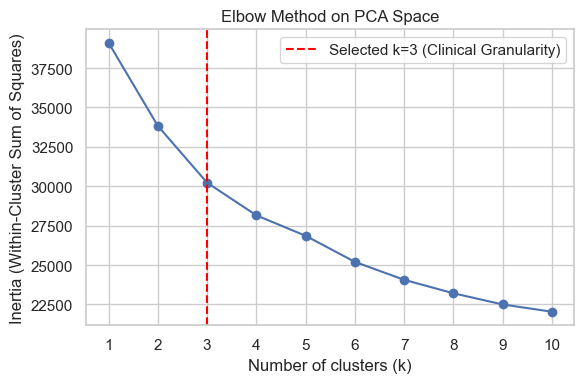

In [53]:
# Elbow Method: K-Means inertia for k = 1..10 on PCA space
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

ks = list(range(1, 11))
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(ks, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method on PCA Space")
plt.xticks(ks)

# Mark the chosen k=3
plt.axvline(x=3, color="red", linestyle="--", label="Selected k=3 (Clinical Granularity)")
plt.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "elbow_kmeans_pca.png", dpi=300)
plt.show()

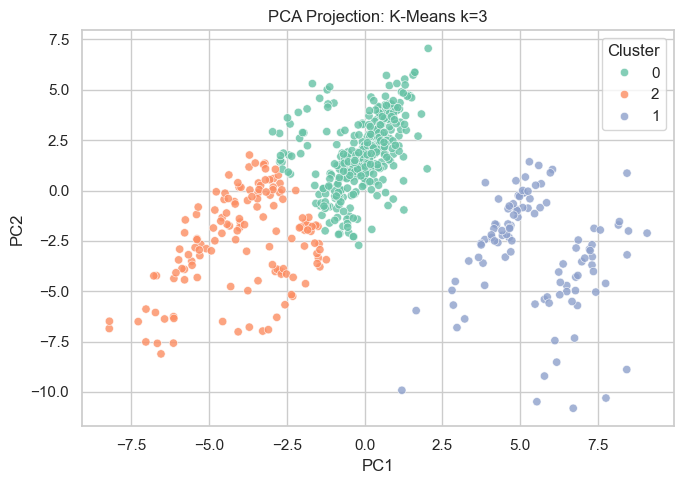

In [54]:
pca_df = X_pca[["PC1", "PC2"]].copy()
pca_df["Cluster"] = labels.astype(str)
plot_pca_scatter(
    pca_df, cluster_col="Cluster", title="PCA Projection: K-Means k=3",
    save_path=str(FIG_DIR / "pca_kmeans_k3.png"),
)

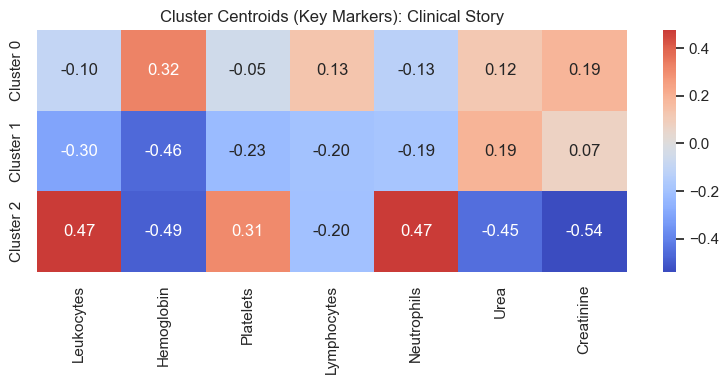

In [55]:
centroids = X.groupby(labels).mean()
centroids.index = [f"Cluster {i}" for i in centroids.index]

markers = ["Leukocytes", "Hemoglobin", "Platelets", "Lymphocytes", "Neutrophils", "Urea", "Creatinine"]
plot_centroid_heatmap(
    centroids,
    markers=[m for m in markers if m in centroids.columns],
    title="Cluster Centroids (Key Markers): Clinical Story",
    save_path=str(FIG_DIR / "centroid_heatmap_k3.png"),
)

Silhouette (K-Means, k=3): 0.180
Silhouette (GMM, k=3):     0.182


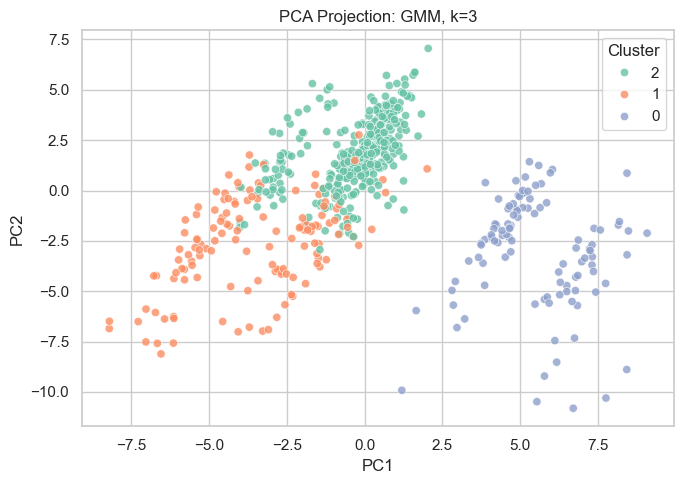

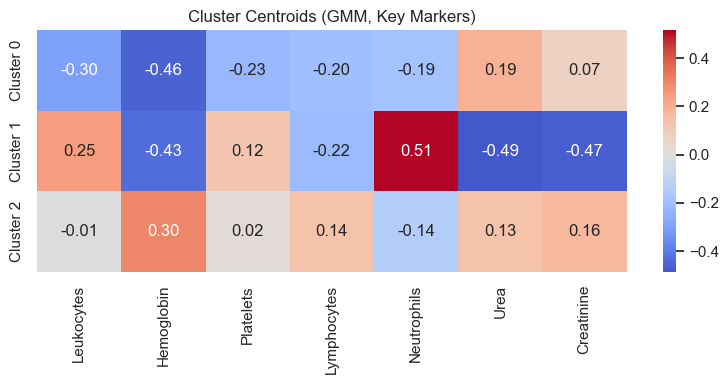

In [56]:
# Optional: Compare with Gaussian Mixture Model (GMM)
from sklearn.metrics import silhouette_score

# Reuse the same PCA representation `X_pca`
clustering_gmm = ClinicalClustering(n_clusters=3, method="gmm")
labels_gmm = clustering_gmm.fit_predict(X_pca)

# Simple unsupervised quality check (silhouette)
sil_kmeans = silhouette_score(X_pca, labels)
sil_gmm = silhouette_score(X_pca, labels_gmm)
print(f"Silhouette (K-Means, k=3): {sil_kmeans:.3f}")
print(f"Silhouette (GMM, k=3):     {sil_gmm:.3f}")

# PCA scatter for GMM
pca_df_gmm = X_pca[["PC1", "PC2"]].copy()
pca_df_gmm["Cluster"] = labels_gmm.astype(str)
plot_pca_scatter(
    pca_df_gmm,
    cluster_col="Cluster",
    title="PCA Projection: GMM, k=3",
    save_path=str(FIG_DIR / "pca_gmm_k3.png"),
)

# Centroid-like summary for GMM (mean of original features per cluster)
centroids_gmm = X.groupby(labels_gmm).mean()
centroids_gmm.index = [f"Cluster {i}" for i in centroids_gmm.index]
markers = [
    "Leukocytes", "Hemoglobin", "Platelets",
    "Lymphocytes", "Neutrophils", "Urea", "Creatinine",
]
plot_centroid_heatmap(
    centroids_gmm,
    markers=[m for m in markers if m in centroids_gmm.columns],
    title="Cluster Centroids (GMM, Key Markers)",
    save_path=str(FIG_DIR / "centroid_heatmap_gmm_k3.png"),
)

## 5. Model Selection & Conclusion

We compared two clustering approaches on the PCA space, both with three clusters. K-Means achieved a Silhouette score of 0.180; the Gaussian mixture model (GMM) came in at 0.182. In practice, the two solutions look almost the same: three compact patient groups that sit clearly apart in the first two principal components.

The difference between the two scores is tiny (about 0.002), and we had no strong reason to prefer one over the other on numbers alone. What tipped the balance was interpretability. For clinical use we want a single, clear label per patient (mild, moderate, or severe), not a mix of probabilities. K-Means gives exactly that, with straightforward centroids and a simple story for clinicians. We therefore use K-Means with k=3 as our main phenotyping model. The cluster labels are saved in `data/processed/02_clustered_data.csv` and will serve as the reference phenotypes for the statistical validation and outcome analyses in Notebook 03.